In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%matplotlib inline
sns.set('notebook')
sns.set_style('whitegrid')

### Import GRIMM data
Convert epoch to date-times and visualize relationships in data

In [5]:
grimm = pd.read_csv('data/humexp/Grimm.csv', index_col='EpochTime', header=False, names=['EpochTime','Count','PM1', 'PM10', 'PM2.5'])
grimm.index = pd.to_datetime((grimm.index.values*1e9).astype(int))

In [6]:
grimm.head()

,Count,PM1,PM10,PM2.5
2015-06-30 15:24:21,130450,10.5,10.5,10.5
2015-06-30 15:24:27,128050,10.0,17.2,10.6
2015-06-30 15:24:33,126550,10.0,14.9,11.5
2015-06-30 15:24:39,124700,10.0,10.7,10.7
2015-06-30 15:24:45,126700,9.7,15.2,10.5


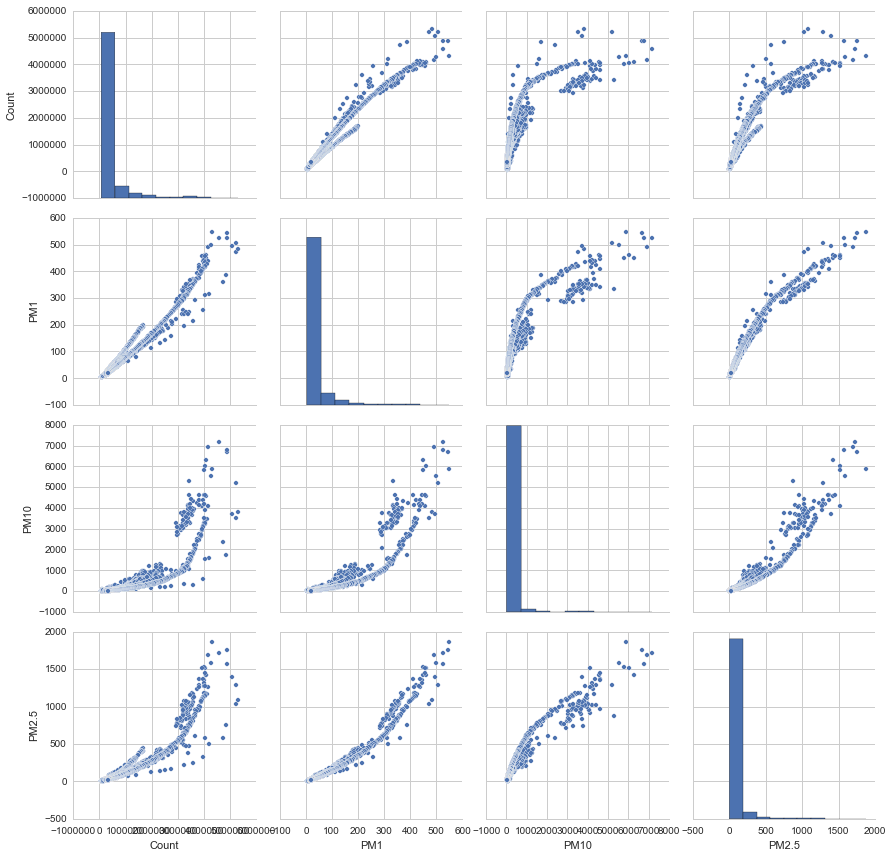

In [7]:
sns.pairplot(grimm)

### Import Speck data
Drop extra rows and convert epoch timestamps to date-times

In [8]:
speck1 = pd.read_csv('data/humexp/Speck1.csv', index_col='EpochTime', header=False, names=['EpochTime','Humidity', 'Concentration', 'Count', 'Raw', 'Temp'])
speck2 = pd.read_csv('data/humexp/Speck2.csv', index_col='EpochTime', header=False, names=['EpochTime','Humidity', 'Concentration', 'Count', 'Raw', 'Temp'])

speck1 = speck1.iloc[2:]
speck2 = speck2.iloc[1:]

speck1.index = pd.to_datetime((speck1.index.values*1e9).astype(int))
speck2.index = pd.to_datetime((speck2.index.values*1e9).astype(int))

In [9]:
speck1.head()

,Humidity,Concentration,Count,Raw,Temp
2015-06-30 15:24:24,93,1.9,49,11,0.1
2015-06-30 15:25:24,81,2.6,66,19,3.1
2015-06-30 15:26:24,73,4.1,102,59,5.5
2015-06-30 15:27:24,67,5.3,133,4,7.3
2015-06-30 15:28:24,63,5.1,127,20,8.6


### Resample data to common interval of 1 minute

In [10]:
speck1 = speck1.resample('1Min').dropna()
speck2 = speck2.resample('1Min').dropna()
grimm = grimm.resample('1Min').dropna()

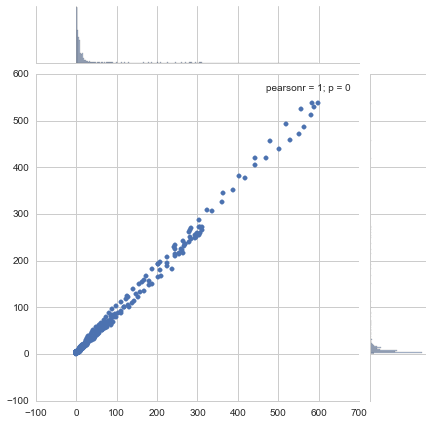

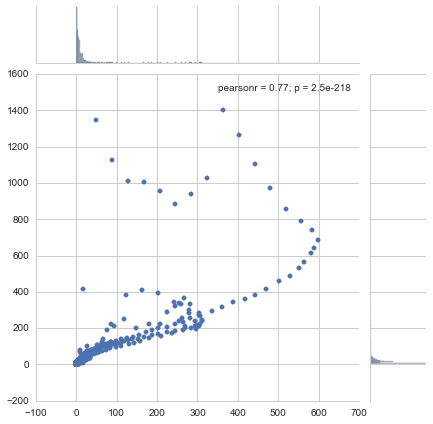

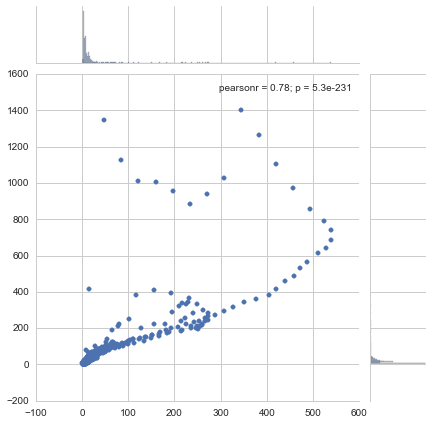

In [11]:
sns.jointplot(speck1['Concentration'].values, speck2['Concentration'].values)
sns.jointplot(speck1['Concentration'].values, grimm['PM2.5'].values)
sns.jointplot(speck2['Concentration'].values, grimm['PM2.5'].values)

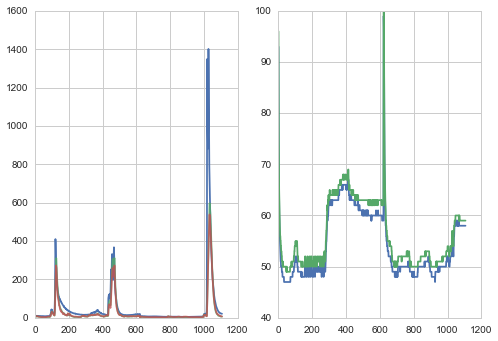

In [12]:
plt.subplot(121)
plt.plot(grimm['PM2.5'])
plt.plot(speck1['Concentration'], alpha=0.8)
plt.plot(speck2['Concentration'], alpha=0.8)
plt.subplot(122)
plt.plot(speck1['Humidity'])
plt.plot(speck2['Humidity'])

### Learning a better fit to PM2.5

In [13]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, LinearRegression

Compare two predictors, SVM may overfit the training data, linear ridge regression will not be able to overfit if $d<<n$

In [14]:
predictors = {'Ridge': make_pipeline(StandardScaler(), PolynomialFeatures(2), Ridge()),
             'RBF SVM': make_pipeline(StandardScaler(), SVR(kernel='rbf', C=1e4, epsilon=1, degree=3))}

# Note, RBF parameters were not tunes with a validation set, but with the test set.  
# This is more of an exploration and is not suitable for publication

In [15]:
results = {}
X = speck1.iloc[:500].values
y = grimm['PM2.5'].iloc[:500]
testX = speck1.iloc[500:].values
testy = grimm['PM2.5'].iloc[500:]

#X = speck1.iloc[::2].values
#y = grimm['PM2.5'].iloc[::2]
#testX = speck1.iloc[1::2].values
#testy = grimm['PM2.5'].iloc[1::2]

for label in predictors:
    regressor = predictors[label]
    regressor.fit(X, y)
    results[label] = regressor.predict(testX)

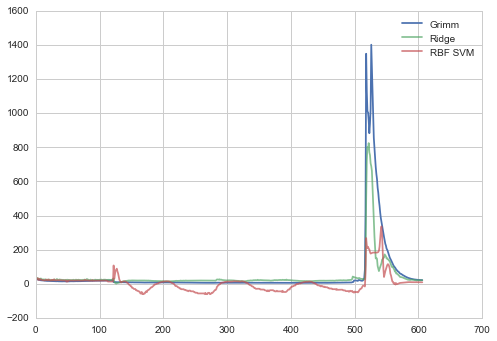

In [16]:
plt.subplot(111)
plt.plot(testy, label='Grimm')
for label in results:
    plt.plot(results[label], label=label, alpha=0.7)
plt.legend()

In [ ]:
print 'Training data fit scores'
for label in predictors:
    print label + ' ' + str(predictors[label].score(speck1.iloc[::2].values, grimm['PM2.5'].iloc[::2]))

For each feautre (polynomial combination of features), what is the respective weight in the ridge regressor?

In [ ]:
print speck1.columns
print zip(predictors['Ridge'].steps[1][1].powers_, predictors['Ridge'].steps[2][1].coef_)